<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/Python-Machine-Learning/blob/master/19-Practical_Autoencoders.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/Python-Machine-Learning/blob/master/19-Practical_Autoencoders.ipynb)

# 19. Practical Autoencoders

+ [**19.1 認識自編碼器**](#whatis-autoencoder)
+ [**19.2 淺層自編碼器 Shallow Autoencoder**](#shallow-autoencoder)
+ [**19.3 深層自編碼器 Deep Autoencoder**](#deep-autoencoder)
+ [**19.4 稀疏自編碼器 Sparse Autoencoder**](#sparse-autoencoder)
+ [**19.5 去雜訊自編碼器 Denoising Autoencoder**](#denoising-autoencoder)
+ [**19.6 自編碼器應用 － 異常偵測 Anomaly Detection**](#anomaly-detection)
    - [**19.6.1 不平衡分類的評估 Evaluting the Imbalanced Classification**](#evaluating-imbalanced-classification)
+ [**參考資料**](#references)

<a id="whatis-autoencdoer"></a>

## 19.1 認識自編碼器

Autoencoder 是一種特殊的 Feedforward 類神經網路（沒有 Recurrent Neural Network 的回溯連結），有一個隱藏層 $h$ 內含某種編碼（code），網路被訓練來盡可能把輸入重現到輸出，訓練的方法一樣使用倒傳遞及梯度下降的演算法。 Autoencoder 的結構可以看成包含兩個部分：
+ **Encoder** － 編碼函數 $h = f(x)$ 將輸入 $x$ 編碼成 $h$。
+ **Decoder** － 解碼函數 $x' = g(h)$ 由編碼 $h$ 重建成 $x'$。

乍看之下，把輸入一對一直接複製到輸出 $x \to x$ 完全沒有誤差，這樣就搞定了啊？ 這樣可以做什麼？ 看起來一點用處都沒有。 但事實上 Autoencoder 是會經過設計以避免完美複製輸入的，也正因為刻意經過調節的部分才會被複製到輸出，所以往往可以從輸入資料學習到有用的特質。 由於是從樣本中自動學習資料的特質，這讓針對特定輸入要訓練一個特定的演算模型變得容易，不需要額外的標籤標註，只需要蒐集適合的輸入資料，所以 Autoencoder 的學習比較屬於是非監督式（unsupervised）的，或跟精確地說是自監督式（self-supervised）的學習。

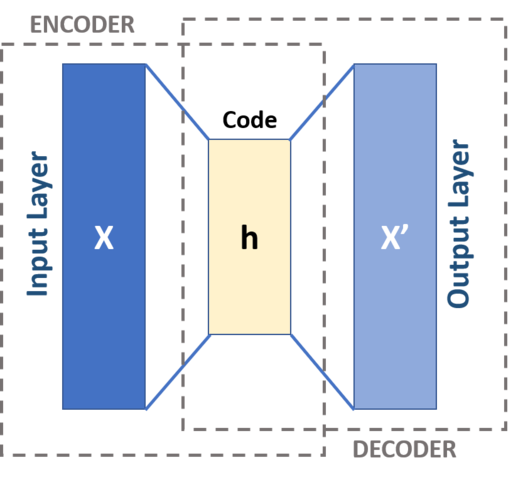

Autoencoder 有一種基本萃取特徵的方法，就是限制編碼 $h$ 的維度小於輸入 $x$，稱為 **undercomplete**。 已知若不加其他限制，增加隱藏層數（增強非線性編碼能力）、使用編碼層與輸入相同維度的結構、或編碼層維度高於輸入的結構（**overcomplete**），都會導致 decoder 學習將輸入複製到輸出，而沒有真正學習到輸入資料的分布特性。

經過多年的發展，Autoencoder 衍生出了一些不同的結構，也在一些應用上展現了有趣又有用的成效。 經典的應用如特徵學習特徵學習、降低特徵維度、去雜訊、以及異常偵測，近年來熱門的則是將 Autoencoder 用在生成模型（Generative Model）。

In [1]:
# 基本環境設定
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

<a id="shallow-autoencoder"></a>

## 19.2 淺層自編碼器 Shallow Autoencoder

### 載入 MNIST 資料集

使用常用的 MNIST 手寫數字資料集，Keras 有內建方便的載入工具。

In [2]:
mnist = tf.keras.datasets.mnist

# 利用 keras 內建的函式庫載入 mnist 資料集，標籤 y_train 及 y_test 用不到
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 檢視維度、大小、以及資料型態
print('x_train: shape={}, dtype={}'.format(x_train.shape, x_train.dtype))
print('x_test: shape={}, dtype={}'.format(x_test.shape, x_test.dtype))

x_train: shape=(60000, 28, 28), dtype=uint8
x_test: shape=(10000, 28, 28), dtype=uint8


In [3]:
# 將影像正規化在 [0,1] 範圍
x_train = x_train.astype('float') / 255.
x_test = x_test.astype('float') / 255.

# 第一維樣本數不變，影像從二維 28x28 調整為 784 的一維向量
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

# 檢視調整後的維度、大小、以及資料型態
print('x_train: shape={}, dtype={}'.format(x_train.shape, x_train.dtype))
print('x_test: shape={}, dtype={}'.format(x_test.shape, x_test.dtype))

x_train: shape=(60000, 784), dtype=float64
x_test: shape=(10000, 784), dtype=float64


### 建構自編碼器

首先示範建構一個非常淺層、簡單的、降低特徵維度的、壓縮編碼的 Autoencoder 來學習手寫數字的特徵。 另外，這個 Autoencoder 模型中的編碼器及解碼器也刻意擷取出來，以方便觀察及比較。

In [4]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Model = tf.keras.models.Model

def shallow_autoencoder(input_size=784, code_size=32):
    '''建立淺層自編碼器模型
    自編碼器的 input size = output size
    預設參數由 784 -> 32 壓縮比為 24.5
    '''
    # 輸入層
    inputs = Input(shape=(input_size,))
    # "encoded" 是編碼後的輸入
    encoded = Dense(code_size, activation='relu')(inputs)
    # "decoded" 是有損失重建的輸入
    decoded = Dense(input_size, activation='sigmoid')(encoded)

    # 建立輸入對應到解碼輸出的模型
    autoencoder = Model(inputs=inputs, outputs=decoded)

    # 指定訓練過程採用的最佳化演算法及每個像素的損失函數
    autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')
    
    # 除了自編碼器模型外，也返回 encoder 以方便觀察編碼結果
    # 建立編碼器模型對應到 autoencoder 編碼結果
    encoder = Model(inputs=inputs, outputs=encoded)
    
    return autoencoder, encoder

### 訓練自編碼器模型

注意 Autoencoder 訓練的方式，原本是 y_train 的地方要改傳入 x_train。 所以會說 Autoencoder 不完全是非監督式學習，只是因為要比對的答案就是輸入資料本身，所以不需要額外的標籤。

In [5]:
shallow_ae, shallow_ae_encdoer = shallow_autoencoder(input_size=784, code_size=32)

# 訓練時，原本是 y_train 的地方，改傳入 x_train
shallow_ae.fit(x_train,
               x_train,
               epochs=25,
               batch_size=256,
               shuffle=True,
               validation_data=(x_test, x_test))

Instructions for updating:
Colocations handled automatically by placer.
Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2262 - val_loss: 0.1573
Epoch 2/25
60000/60000 [==============================] - 4s 70us/sample - loss: 0.1393 - val_loss: 0.1245
Epoch 3/25
60000/60000 [==============================] - 4s 69us/sample - loss: 0.1173 - val_loss: 0.1102
Epoch 4/25
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1073 - val_loss: 0.1027
Epoch 5/25
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1023 - val_loss: 0.1024
Epoch 6/25
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0997 - val_loss: 0.0965
Epoch 7/25
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0973 - val_loss: 0.0959
Epoch 8/25
60000/60000 [==============================] - 4s 70us/sample - loss: 

### 繪圖工具函式

在畫面顯示原始影像，以及經過 Autoencoder 編碼、解碼重建的結果。

In [6]:
import matplotlib.pyplot as plt
import random

def plot_autoencoder_outputs(original_imgs, encoded_imgs, decoded_imgs, n_imgs=9):
    fig, ax = plt.subplots(nrows=3, ncols=n_imgs, figsize=(20, 6))

    for n,k in enumerate(random.sample(range(original_imgs.shape[0]), k=n_imgs)):
        # 上面列顯示原始影像
        ax[0,n].imshow(original_imgs[k].reshape(28,28), cmap='gray')
        ax[0,n].get_xaxis().set_visible(False)
        ax[0,n].get_yaxis().set_visible(False)
        if n == n_imgs//2:
            ax[0,n].set_title('Original Images', fontsize=16)
  
        # 中間列顯示編碼後影像
        ax[1,n].imshow(encoded_imgs[k].reshape(4,8), cmap='gray')
        ax[1,n].get_xaxis().set_visible(False)
        ax[1,n].get_yaxis().set_visible(False)
        if n == n_imgs//2:
            ax[1,n].set_title('Encoded Images', fontsize=16)

        # 下面列顯示自編碼器解碼重建的影像 
        ax[2,n].imshow(decoded_imgs[k].reshape(28,28), cmap='gray')
        ax[2,n].get_xaxis().set_visible(False)
        ax[2,n].get_yaxis().set_visible(False)
        if n == n_imgs//2:
            ax[2,n].set_title('Reconstructed Images', fontsize=16)
    plt.show()

### 檢視訓練結果

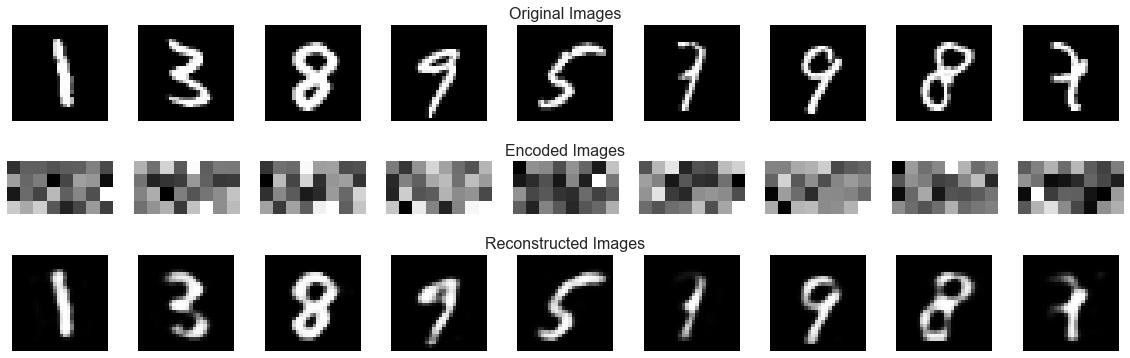

In [7]:
# 拿測試集影像輸入編碼器
encoded_imgs = shallow_ae_encdoer.predict(x_test)
# 編碼結果再輸入解碼器
decoded_imgs = shallow_ae.predict(x_test)
# 劃出編碼解碼的比較圖
plot_autoencoder_outputs(x_test, encoded_imgs, decoded_imgs)

<a id="deep-autoencoder"></a>

## 19.3 深層自編碼器 Deep Autoencoder

將隱藏層加深、節點增廣，可以很明顯看到自編碼器的學習力增強，但要注意是否學習能力過強，導致輸入直接複製到輸出而沒有學到任何有用的特徵。 

### 建構深層自編碼器

In [8]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Model = tf.keras.models.Model

def deep_autoencoder(input_size=784, hidden_units=[128, 64], code_size=32):
    '''建立深層自編碼器模型
    自編碼器的 input size = output size
    隱藏層節點數順序為： hidden_units[0], hidden_units[1], code, hidden_units[1], hidden_units[0]
    '''
    # 輸入層
    inputs = Input(shape=(input_size,))
    # 編碼層
    encoded = Dense(hidden_units[0], activation='relu')(inputs)
    encoded = Dense(hidden_units[1], activation='relu')(encoded)
    encoded = Dense(code_size, activation='relu')(encoded)
    # 解碼層
    decoded = Dense(hidden_units[1], activation='relu')(encoded)
    decoded = Dense(hidden_units[0], activation='relu')(decoded)
    decoded = Dense(input_size, activation='sigmoid')(decoded)
  
    # 建立輸入對應到解碼輸出的模型
    autoencoder = Model(inputs=inputs, outputs=decoded)
    # 指定訓練過程採用的最佳化演算法及每個像素的損失函數
    autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')
    
    # 編碼器
    encoder = Model(inputs=inputs, outputs=encoded)
    
    return autoencoder, encoder

### 訓練深層自編碼器

同樣的 epochs 迭代訓練次數下，已經可以看出淺層與深層的差異，再給深層網路多訓練幾個 epochs 的話 loss 會更小。 不過還是要記得，一比一的精確度不是自編碼器要學習的目標。

In [9]:
deep_ae, deep_ae_encdoer = deep_autoencoder(input_size=784, hidden_units=[128, 64], code_size=32)

# 深層網路可能多訓練幾個 epochs 會更好
deep_ae.fit(x_train,
            x_train,
            epochs=25,
            batch_size=256,
            shuffle=True,
            validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 6s 107us/sample - loss: 0.2174 - val_loss: 0.1653
Epoch 2/25
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1523 - val_loss: 0.1406
Epoch 3/25
60000/60000 [==============================] - 6s 96us/sample - loss: 0.1379 - val_loss: 0.1351
Epoch 4/25
60000/60000 [==============================] - 6s 96us/sample - loss: 0.1293 - val_loss: 0.1281
Epoch 5/25
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1230 - val_loss: 0.1176
Epoch 6/25
60000/60000 [==============================] - 6s 96us/sample - loss: 0.1180 - val_loss: 0.1160
Epoch 7/25
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1143 - val_loss: 0.1097
Epoch 8/25
60000/60000 [==============================] - 6s 96us/sample - loss: 0.1112 - val_loss: 0.1106
Epoch 9/25
60000/60000 [==============================] - 6s 96us/sample - loss: 0.1086 - val

### 檢視訓練結果

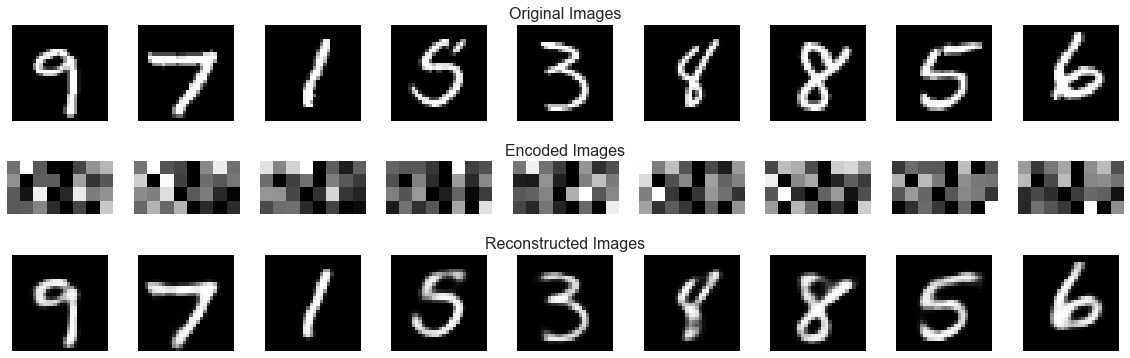

In [10]:
# 拿測試集影像輸入編碼器
deep_encoded_imgs = deep_ae_encdoer.predict(x_test)
# 編碼結果再輸入解碼器
deep_decoded_imgs = deep_ae.predict(x_test)
# 劃出編碼解碼的比較圖
plot_autoencoder_outputs(x_test, deep_encoded_imgs, deep_decoded_imgs)

<a id="sparse-autoencoder"></a>

## 19.4 稀疏自編碼器 Sparse Autoencoder

另外一種用來約束編碼，使得盡可能壓縮得很精簡的方法，就是鼓勵激活的神經元稀疏化，叫做 Sparse Autoencoder。 跟訓練 DNN 時用的 regularization 方式一樣，就是在 loss function 加上懲罰項，以 L1 regularizer 的稀疏化效果比較好。

### 建構稀疏自編碼器

In [11]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Model = tf.keras.models.Model
L1 = tf.keras.regularizers.l1

def sparse_autoencoder(input_size=784, hidden_units=[128, 64], code_size=32):
    '''建立稀疏的深層自編碼器模型
    自編碼器的 input size = output size
    隱藏層節點數順序為： hidden_units[0], hidden_units[1], code, hidden_units[1], hidden_units[0]
    '''
    # 輸入層
    inputs = Input(shape=(input_size,))
    # 編碼層多加了 L1 regularizer
    encoded = Dense(hidden_units[0], activation='relu', activity_regularizer=L1(1e-3))(inputs)
    encoded = Dense(hidden_units[1], activation='relu', activity_regularizer=L1(1e-4))(encoded)
    encoded = Dense(code_size, activation='relu')(encoded)
    # 解碼層
    decoded = Dense(hidden_units[1], activation='relu')(encoded)
    decoded = Dense(hidden_units[0], activation='relu')(decoded)
    decoded = Dense(input_size, activation='sigmoid')(decoded)
  
    # 建立輸入對應到解碼輸出的模型
    autoencoder = Model(inputs=inputs, outputs=decoded)
    # 指定訓練過程採用的最佳化演算法及每個像素的損失函數
    autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')
    
    # 編碼器
    encoder = Model(inputs=inputs, outputs=encoded)
    
    return autoencoder, encoder

### 訓練稀疏深層自編碼器

In [12]:
sparse_ae, sparse_ae_encdoer = sparse_autoencoder(input_size=784, hidden_units=[128, 64], code_size=32)

# 稀疏深層自編碼器需要再多訓練幾個 epochs
sparse_ae.fit(x_train,
              x_train,
              epochs=35,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/35
60000/60000 [==============================] - 7s 109us/sample - loss: 0.2443 - val_loss: 0.1928
Epoch 2/35
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1784 - val_loss: 0.1695
Epoch 3/35
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1659 - val_loss: 0.1612
Epoch 4/35
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1585 - val_loss: 0.1538
Epoch 5/35
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1527 - val_loss: 0.1524
Epoch 6/35
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1481 - val_loss: 0.1517
Epoch 7/35
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1440 - val_loss: 0.1431
Epoch 8/35
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1407 - val_loss: 0.1387
Epoch 9/35
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1377 - val

### 檢視訓練結果

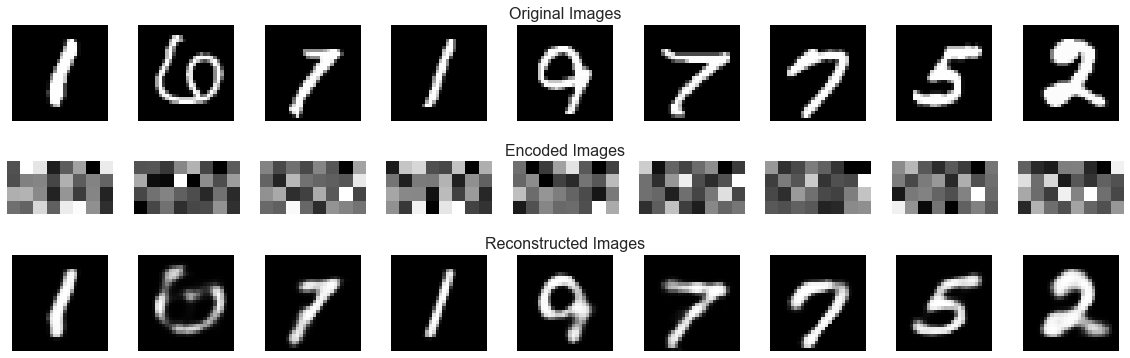

In [13]:
# 測試稀疏編碼及解碼重建
sparse_encoded_imgs = sparse_ae_encdoer.predict(x_test)
sparse_decoded_imgs = sparse_ae.predict(x_test)
# 劃出編碼解碼的比較圖
plot_autoencoder_outputs(x_test, sparse_encoded_imgs, sparse_decoded_imgs)

### 稀疏編碼的比較

上述範例中的 `deep_autoencoder()` 與 `sparse_autoencoder()` 只差別在編碼層多加了 L1 regularization。 由於 Sparse Autoencoder 在 loss 多增加了懲罰項，所以無法從 loss 數值比較訓練結果是否達到相同水準。 但從視覺觀察的結果，上面兩種自編碼器的解碼重建結果差不多。 若觀察編碼結果的數值分布狀況，可以發現 Sparse Autoencoder 的編碼結果相對較多接近 0 的數值。

deep 編碼平均 = 5.110195
sparse 編碼平均 = 1.068651


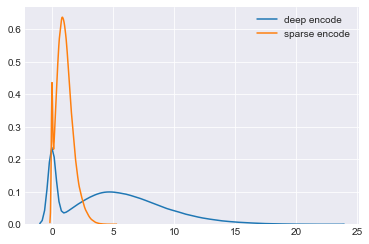

In [14]:
import seaborn as sns

sns.distplot(deep_encoded_imgs.reshape(-1), hist=False, label='deep encode')
sns.distplot(sparse_encoded_imgs.reshape(-1), hist=False, label='sparse encode')

print('deep 編碼平均 =', deep_encoded_imgs.mean())
print('sparse 編碼平均 =', sparse_encoded_imgs.mean())

<a id="denoising-autoencoder"></a>

## 19.5 去雜訊自編碼器 Denoising Autoencoder

還有一種有趣的手法可以讓自編碼器學習有用的特徵，那就是刻意在輸入加上雜訊，但學習重建的目標仍然是原始資料。 這樣一來就強迫自編碼器不能直接複製輸入到輸出，所以在訓練過程，自編碼器就會學習去除雜訊下的有用的資訊。

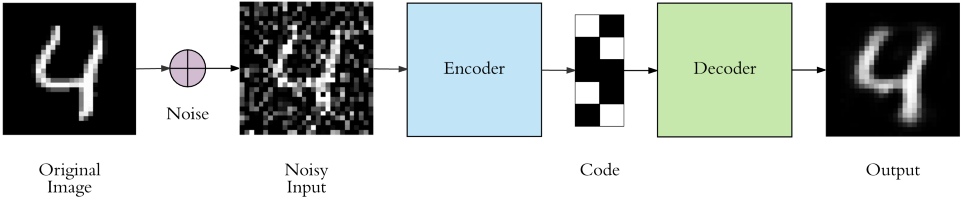

### 產生帶雜訊的訓練資料

In [15]:
# 將雜訊加入訓練資料
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

### 輸入雜訊資料比對原始資料

由於部分原始資料已經被破壞，要由帶雜訊的資料中學習原來的特徵，會需要更長的訓練時間。

In [16]:
# 用 deep autoencoder 的模型來訓練
denoising_ae, denoising_ae_encdoer = deep_autoencoder(input_size=784, hidden_units=[128, 64], code_size=32)

# 輸入 X 是有雜訊的訓練資料，比對 Y 是沒有雜訊的訓練資料
denoising_ae.fit(x_train_noisy,
                 x_train,
                 epochs=50,
                 batch_size=256,
                 shuffle=True,
                 validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 110us/sample - loss: 0.2389 - val_loss: 0.1840
Epoch 2/50
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1723 - val_loss: 0.1587
Epoch 3/50
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1574 - val_loss: 0.1537
Epoch 4/50
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1486 - val_loss: 0.1451
Epoch 5/50
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1426 - val_loss: 0.1390
Epoch 6/50
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1381 - val_loss: 0.1376
Epoch 7/50
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1344 - val_loss: 0.1322
Epoch 8/50
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1313 - val_loss: 0.1336
Epoch 9/50
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1287 - val

In [17]:
import matplotlib.pyplot as plt
import random

def plot_denoising_outputs(original_imgs, noisy_imgs, denoising_imgs, decoded_imgs, n_imgs=9):
    fig, ax = plt.subplots(nrows=4, ncols=n_imgs, figsize=(20, 10))

    for n,k in enumerate(random.sample(range(original_imgs.shape[0]), k=n_imgs)):
        # 上面列顯示原始影像
        ax[0,n].imshow(original_imgs[k].reshape(28,28), cmap='gray')
        ax[0,n].get_xaxis().set_visible(False)
        ax[0,n].get_yaxis().set_visible(False)
        if n == n_imgs//2:
            ax[0,n].set_title('Original Images', fontsize=16)
  
        # 顯示有雜訊的影像
        ax[1,n].imshow(noisy_imgs[k].reshape(28,28), cmap='gray')
        ax[1,n].get_xaxis().set_visible(False)
        ax[1,n].get_yaxis().set_visible(False)
        if n == n_imgs//2:
            ax[1,n].set_title('Noisy Inputs', fontsize=16)

        # 顯示雜訊重建後的影像
        ax[2,n].imshow(denoising_imgs[k].reshape(28,28), cmap='gray')
        ax[2,n].get_xaxis().set_visible(False)
        ax[2,n].get_yaxis().set_visible(False)
        if n == n_imgs//2:
            ax[2,n].set_title('Reconstructed Noisy Images', fontsize=16)

        # 下面列顯示原始自編碼器解碼重建的影像 
        ax[3,n].imshow(decoded_imgs[k].reshape(28,28), cmap='gray')
        ax[3,n].get_xaxis().set_visible(False)
        ax[3,n].get_yaxis().set_visible(False)
        if n == n_imgs//2:
            ax[3,n].set_title('Reconstructed Original Images', fontsize=16)
    plt.show()

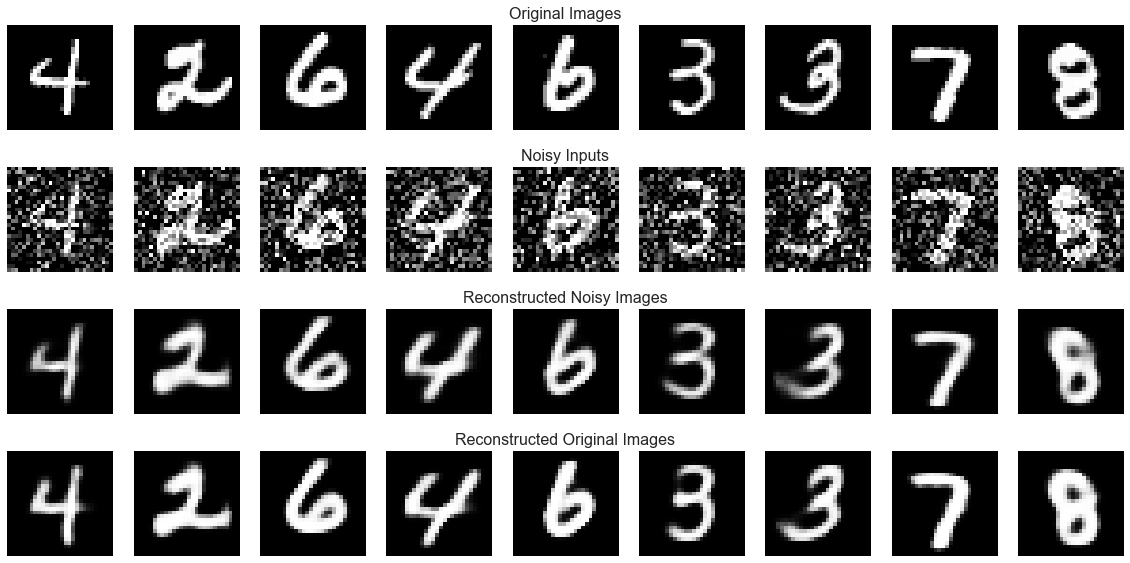

In [18]:
# 原始的輸入重建
decoded_imgs = denoising_ae.predict(x_test)
# 測試去雜訊重建
denoising_imgs = denoising_ae.predict(x_test_noisy)
# 畫出比較圖
plot_denoising_outputs(x_test, x_test_noisy, denoising_imgs, decoded_imgs)

<a id="anomaly-detection"></a>

## 19.6 自編碼器應用 － 異常偵測 Anomaly Detection

真實世界中不論是哪個領域，工業、商業、醫學 ... 等領域都是，有需要異常偵測的應用，通常可以取得的異常資料就是特別的少。 以下的範例採用的資料是來自 [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) 的信用卡詐騙交易資料集。

這個資料集包含了歐洲的持卡人在 2013 年 9 月的某兩天中的交易記錄，共有 284,807 筆交易記錄，其中只有 492 筆（0.172%）是詐騙交易。 總共 30 個特徵欄位，欄位 ***V1***, ***V2***, ... ***V28*** 全部是轉換自原始數據的 PCA 主成分而來的，原始的背景資料基於保護隱私所以不提供。 只有 ***Time*** 和 ***Amount*** 兩個欄位沒有經過 PCA 的轉換，*Time* 是由記錄的第一筆交易開始所經過的秒數，*Amount* 則是交易的金額。 標籤欄位 ***Class*** 標示每一筆交易是正常（0）還是異常（1）。

### 載入資料集與基本檢視

由 Kaggle 下載的資料集檔案為 "creditcardfraud.zip"，解壓縮後使用 `read_csv()` 讀取 "creditcard.csv" 檔案。

In [19]:
from  zipfile import ZipFile

with ZipFile('./dataset/FraudDetection/creditcardfraud.zip', 'r') as cardzip:
    cardzip.extractall('./dataset/FraudDetection/')

In [20]:
import pandas as pd

dfcard = pd.read_csv('./dataset/FraudDetection/creditcard.csv')

# 檔案相當大，讀取後 .cvs 檔就不需要了
from pathlib import Path
Path('./dataset/FraudDetection/creditcard.csv').unlink()

In [21]:
# 資料欄位基本檢視
dfcard.info()

# 284807 筆，沒有 NaN 漏失數據

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [22]:
# 檢視前幾筆數據
dfcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [23]:
# 檢視基本統計分布狀況
dfcard.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


欄位 *V1*, *V2*, ... *V28* 轉換自原始數據的 PCA 主成分，所以數值尺度的差異不會太大，*Time* 和 *Amount* 欄位的尺度就與其他欄位的差異較大，要使用這兩個特徵欄位的話，就需要做正規化以調整尺度。

### Imbalanced Classification

檢視正常與異常類別的分布狀況，在*Class* 欄位中，正常為 0 ，異常為 1。 交易樣本總數為 **284,807**，數量分別為正常 **284,315** 筆；異常 **492** 筆。 

In [24]:
# 檢視正常與異常類別的分布狀況
# 正常： 0
# 異常： 1
dfcard['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

這種類別數量分佈極度不平衡的狀況，分析預測結果時需要特別注意。 針對這個信用卡的資料集，如果建了一個模型，預測準確度（accuracy）達到 99%，這個模型是好還是不好？ 

因為這個資料集的類別數量分佈極度不平衡的原因，只要全部猜正常，結果就可以達到 99.83% (284315/284807) 的正確率了，有這麼高的正確率，但希望抓出來的異常類別全部預測錯誤，這當然不是個好模型。

從另外一個角度來看，如果建了一個模型的正確率 93.83%，異常類別全部都正確預測出來，但也有一萬多筆正常的被誤判為異常的，那這是個好模型嗎？ 可能也不是，不過視應用而定，看是處理一兩件異常的成本較高，還是處理大量誤判的成本較高。 但不管是哪一種情形，評估不平衡類別分佈的模型好壞，不能看正確率這個指標。 

### 圖表檢視數據分佈

由於只有知道 *Time* 與 *Amount* 兩個欄位的資料意義，可以先看看這兩個欄位的數據分佈，在正常與異常的類別是否有特別之處。

In [25]:
# 正常的交易金額
dfcard.Amount[dfcard.Class == 0].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [26]:
# 異常的交易金額
dfcard.Amount[dfcard.Class == 1].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

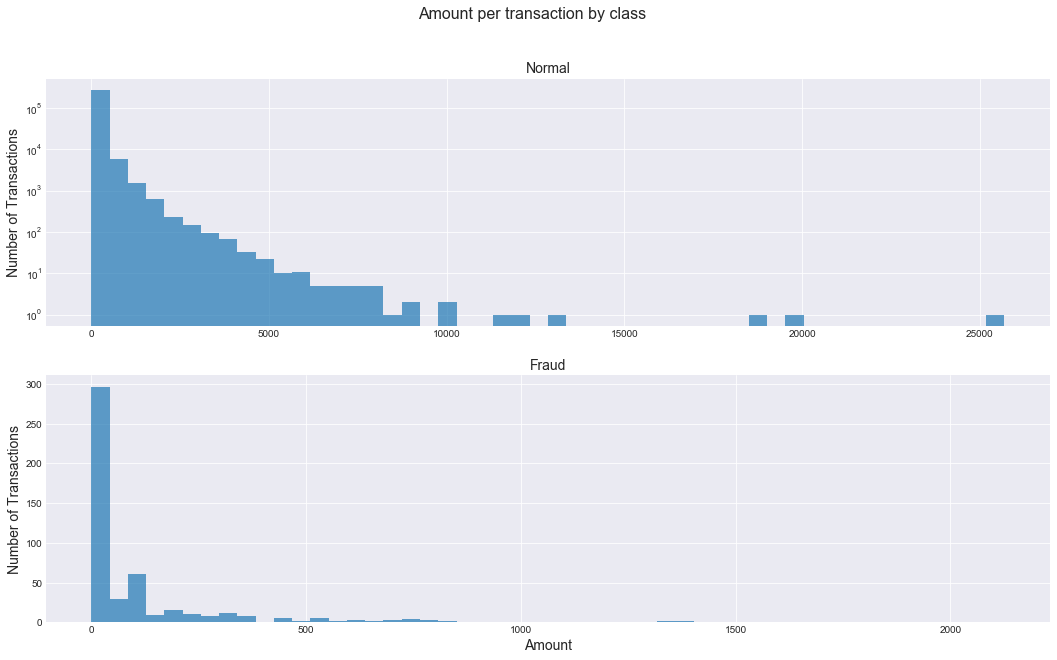

In [28]:
def plot_amount_compare():
    fig, ax = plt.subplots(2, 1, figsize=(18,10))
    fig.suptitle('Amount per transaction by class', fontsize=16)
    bins = 50
    ax[0].hist(dfcard.Amount[dfcard.Class == 0], bins=bins, alpha=0.7)
    ax[0].set_title('Normal', fontsize=14)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Number of Transactions', fontsize=14)
    ax[1].hist(dfcard.Amount[dfcard.Class == 1], bins=bins, alpha=0.7)
    ax[1].set_title('Fraud', fontsize=14)
    ax[1].set_xlabel('Amount', fontsize=14)
    ax[1].set_ylabel('Number of Transactions', fontsize=14)
    plt.show()

plot_amount_compare()

觀察特定時間的交易金額，是否可看出正常與異常交易？

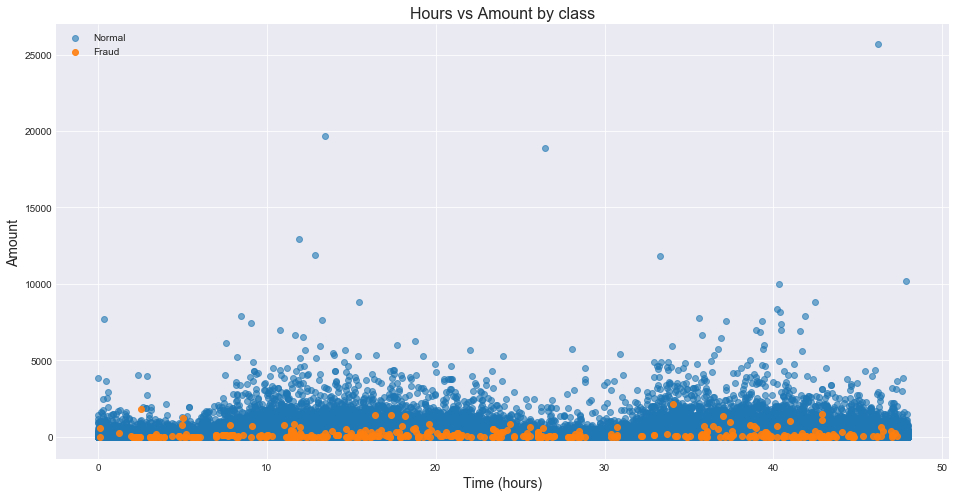

In [29]:
def plot_time_amount():
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.scatter(dfcard.Time[dfcard.Class == 0]/3600, dfcard.Amount[dfcard.Class == 0], alpha=0.6, label='Normal')
    ax.scatter(dfcard.Time[dfcard.Class == 1]/3600, dfcard.Amount[dfcard.Class == 1], alpha=0.9, label='Fraud')
    ax.set_title('Hours vs Amount by class', fontsize=16)
    ax.set_xlabel('Time (hours)', fontsize=14)
    ax.set_ylabel('Amount', fontsize=14)
    ax.legend()
    plt.show()

plot_time_amount()

### Autoencoder 怎麼做異常偵測？

大部分異常偵測都是用相同的概念 － 訓練模型認識足夠多的正常數據，只要碰到不認識的數據，預測結果一定很差，所以預測得很糟糕的那筆輸入就是異常。

基於這樣的概念，只要有足夠多的正常數據，所有學過的的機器學習模型都可以用來做異常偵測，所以我們可以試著建立一個深度自編碼器來訓練看看。 為了方便取一個門檻值來區分好與差的預測，loss function 最好分改成較容易理解的均方差（mean squared error）或絕對差（mean absolute error）。

In [30]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Activation = tf.keras.layers.Activation
BatchNormalization = tf.keras.layers.BatchNormalization
Model = tf.keras.models.Model

def fraud_detect_autoencoder(input_size=30, hidden_units=[24, 12], code_size=6):
    '''建立詐騙偵測自編碼器模型
    '''
    # 輸入層
    inputs = Input(shape=(input_size,))
    # 編碼層
    encoded = Dense(hidden_units[0], activation='tanh')(inputs)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(hidden_units[1], activation='tanh')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(code_size, activation='tanh')(encoded)
    encoded = BatchNormalization()(encoded)
    # 解碼層
    decoded = Dense(hidden_units[1], activation='tanh')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(hidden_units[0], activation='tanh')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(input_size, activation='linear')(decoded)
  
    # 建立輸入對應到解碼輸出的模型
    autoencoder = Model(inputs=inputs, outputs=decoded)
    # 損失函數改成 mean squared error
    autoencoder.compile(optimizer='nadam', loss='mean_squared_error')

    return autoencoder

### 分離訓練資料

異常交易看起來與交易時間 *Time* 比較無關，異常交易金額都集中在小額交易，但最多的正常交易也是小額度的，所以也很難以金額區分，著兩個從特徵欄位抽離應該影響不大。

資料先切割為訓練集與測試集，然後從訓練集將正常與異常的數據分離，我們只需要正常的數據來訓練自編碼器，但在測試集保留正常與異常數據，因為偵測異常是這個應用的目的，測試集會在模型訓練後用來評估預測的效能。

In [59]:
# 抽離不需要的欄位
card_X = dfcard.drop(columns=['Time','Amount']).copy()

# 分離訓練集與測試集
from sklearn.model_selection import train_test_split
# 資料集夠大，10% 的測試集已經夠了，遠比異常數據來得多
X_train, X_test = train_test_split(card_X,
                                   test_size=0.1,
                                   train_size=0.9,
                                   random_state=1,
                                   shuffle=True,
                                   stratify=card_X['Class'])

print('X_train shape =', X_train.shape)
print('X_test shape =', X_test.shape)

X_train shape = (256326, 29)
X_test shape = (28481, 29)


In [60]:
# 正常數據訓練集
X_train_normal = X_train.loc[X_train.Class == 0,:]
# 原本訓練集的異常數據合併到測試集
X_test = pd.concat([X_test, X_train.loc[X_train.Class == 1,:]], axis=0, ignore_index=True)

# X, Y 分離
X_train_normal = X_train_normal.drop(columns=['Class'])
Y_test = X_test['Class']
X_test = X_test.drop(columns=['Class'])

print('X_train_normal shape =', X_train_normal.shape)
print('X_test shape =', X_test.shape)
print('Y_test shape =', Y_test.shape)

X_train_normal shape = (255883, 28)
X_test shape = (28924, 28)
Y_test shape = (28924,)


### 訓練詐騙偵測自編碼器模型

要注意的是，以下範例使用 `fit()` 函式內建的 `validation_split` 參數，在訓練時保留一小部分當驗證集。 在資料集夠大時，是可以不用將全部訓練資料切割成 k-fold 做 k 次驗證，不過實際應用時仍然建議再多做個 2-3 次不同部分的驗證，比較能確認實際模型的最終結果。

In [61]:
fraudet_ae = fraud_detect_autoencoder(input_size=X_train_normal.shape[1], hidden_units=[20, 12], code_size=6)

# 要注意，validation
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="fraudet_model.h5",
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 詐騙偵測自編碼器也是深層網路，可能多訓練幾個 epochs 會更好
history = fraudet_ae.fit(X_train_normal,
                         X_train_normal,
                         epochs=100,
                         batch_size=512,
                         shuffle=True,
                         validation_split=0.1,
                         callbacks=[checkpoint],
                         verbose=1)

Train on 230294 samples, validate on 25589 samples
Epoch 1/100
229888/230294 [============================>.] - ETA: 0s - loss: 0.7188
Epoch 00001: val_loss improved from inf to 0.85348, saving model to fraudet_model.h5
230294/230294 [==============================] - 12s 50us/sample - loss: 0.7185 - val_loss: 0.8535
Epoch 2/100
228352/230294 [============================>.] - ETA: 0s - loss: 0.4717
Epoch 00002: val_loss improved from 0.85348 to 0.51919, saving model to fraudet_model.h5
230294/230294 [==============================] - 6s 25us/sample - loss: 0.4709 - val_loss: 0.5192
Epoch 3/100
228864/230294 [============================>.] - ETA: 0s - loss: 0.3859
Epoch 00003: val_loss improved from 0.51919 to 0.39809, saving model to fraudet_model.h5
230294/230294 [==============================] - 6s 26us/sample - loss: 0.3855 - val_loss: 0.3981
Epoch 4/100
228352/230294 [============================>.] - ETA: 0s - loss: 0.3557
Epoch 00004: val_loss did not improve from 0.39809
2302

Epoch 34/100
228352/230294 [============================>.] - ETA: 0s - loss: 0.2426
Epoch 00034: val_loss did not improve from 0.23411
230294/230294 [==============================] - 6s 24us/sample - loss: 0.2424 - val_loss: 0.2479
Epoch 35/100
229888/230294 [============================>.] - ETA: 0s - loss: 0.2335
Epoch 00035: val_loss did not improve from 0.23411
230294/230294 [==============================] - 6s 25us/sample - loss: 0.2335 - val_loss: 0.2758
Epoch 36/100
229376/230294 [============================>.] - ETA: 0s - loss: 0.2306
Epoch 00036: val_loss did not improve from 0.23411
230294/230294 [==============================] - 6s 25us/sample - loss: 0.2306 - val_loss: 0.2392
Epoch 37/100
229888/230294 [============================>.] - ETA: 0s - loss: 0.2282
Epoch 00037: val_loss improved from 0.23411 to 0.23000, saving model to fraudet_model.h5
230294/230294 [==============================] - 6s 25us/sample - loss: 0.2282 - val_loss: 0.2300
Epoch 38/100
228352/230294

Epoch 69/100
227840/230294 [============================>.] - ETA: 0s - loss: 0.2098
Epoch 00069: val_loss did not improve from 0.21655
230294/230294 [==============================] - 6s 24us/sample - loss: 0.2098 - val_loss: 0.2411
Epoch 70/100
229376/230294 [============================>.] - ETA: 0s - loss: 0.2093
Epoch 00070: val_loss did not improve from 0.21655
230294/230294 [==============================] - 6s 24us/sample - loss: 0.2092 - val_loss: 0.3942
Epoch 71/100
228352/230294 [============================>.] - ETA: 0s - loss: 0.2151
Epoch 00071: val_loss did not improve from 0.21655
230294/230294 [==============================] - 6s 25us/sample - loss: 0.2151 - val_loss: 0.2195
Epoch 72/100
229888/230294 [============================>.] - ETA: 0s - loss: 0.2105
Epoch 00072: val_loss did not improve from 0.21655
230294/230294 [==============================] - 6s 25us/sample - loss: 0.2105 - val_loss: 0.2223
Epoch 73/100
229376/230294 [============================>.] - ET

In [62]:
# 載入儲存的最佳模型
fraudet_ae_model = tf.keras.models.load_model('fraudet_model.h5')

### 觀察訓練記錄

In [63]:
def plot_history(history):
    fig, ax = plt.subplots(figsize=(16, 7))
    ax.set_title('Training vs Validating', fontsize=14)
    ax.plot(history.history['loss'], label='training loss')
    ax.plot(history.history['val_loss'], label='validating loss')
    ax.set_ylabel('Loss', fontsize=14)
    ax.legend()
    plt.show()

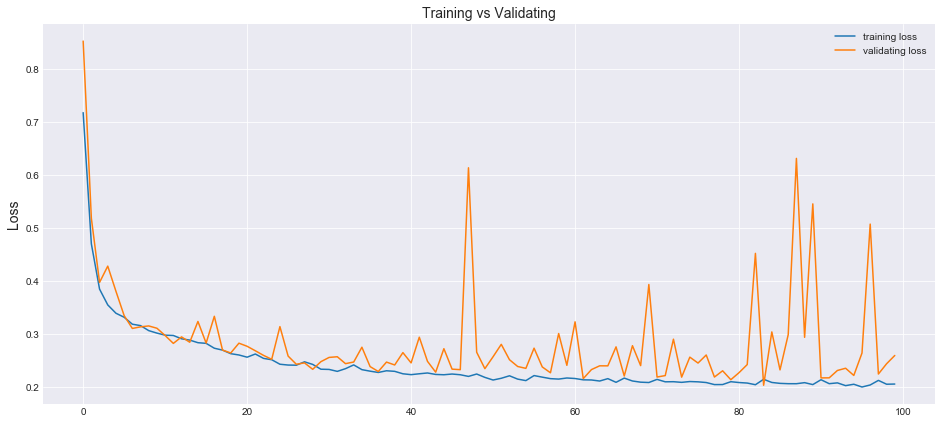

In [64]:
plot_history(history)

### 檢視重建及預測誤差


In [65]:
# 預測測試集
predicts = fraudet_ae_model.predict(X_test)

# 計算 MSE 預測誤差
mse = np.mean(np.power(X_test - predicts, 2), axis=1)

# 檢視預測誤差的數值分佈狀況
df_test_error = pd.DataFrame({'normal_mse': mse[Y_test == 0], 'fraud_mse': mse[Y_test == 1]})
df_test_error.describe()

,normal_mse,fraud_mse
count,28432.000000,492.000000
mean,0.200177,21.911359
std,0.837981,27.835350
min,0.007800,0.017112
25%,0.063026,4.517878
50%,0.104816,9.351678
75%,0.195246,26.080348
max,81.094747,162.912717


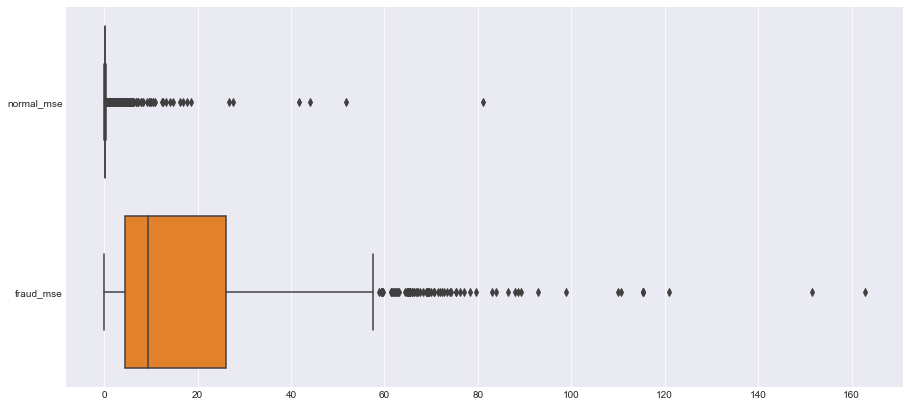

In [66]:
# 圖表觀察
plt.subplots(figsize=(15,7))
sns.boxplot(data=df_test_error, orient='h')

### 誤差門檻與分類

所訓練的模型如果夠精準，那應該可以很容易從預測誤差中看出正常與異常交易的差別。 理想狀況就是取個 MSE 的門檻值，可以一刀切開一群是正常的交易（Negative，陰性），一群是異常的交易（Positive，陽性）。

In [67]:
threshold = 3
# False Positive (FP) 與 False Negative (FN) 的數量
n_FP = (df_test_error['normal_mse'] > threshold).sum()
n_FN = (df_test_error['fraud_mse'] <= threshold).sum()
print('若取門檻值 =', threshold)
print('正常交易高於門檻值（FP）= {} 筆'.format(n_FP))
print('異常交易不高於門檻值（FN）= {} 筆'.format(n_FN))

若取門檻值 = 3
正常交易高於門檻值（FP）= 86 筆
異常交易不高於門檻值（FN）= 99 筆


In [68]:
threshold = 0.3
# False Positive (FP) 與 False Negative (FN) 的數量
n_FP = (df_test_error['normal_mse'] > threshold).sum()
n_FN = (df_test_error['fraud_mse'] <= threshold).sum()
print('若取門檻值 =', threshold)
print('正常交易高於門檻值（FP）= {} 筆'.format(n_FP))
print('異常交易不高於門檻值（FN）= {} 筆'.format(n_FN))

若取門檻值 = 0.3
正常交易高於門檻值（FP）= 4002 筆
異常交易不高於門檻值（FN）= 60 筆


從預測的 MSE 誤差分佈看起來，異常交易的平均與標準差的確有顯著高於正常的交易。 但要從模型的預測誤差中，選一個門檻值來區分正常與異常交易，似乎也沒有想像中那麼容易，不同的應用會有不同成本的考量，門檻值的選擇也會有所差異。

<a id="evaluating-imbalanced-classification"></a>

### 19.6.1 不平衡分類的評估 Evaluting the Imbalanced Classification

一般評估一個二元分類模型的效能，都會看 [**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix) 及 [**ROC curve**](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)。 但是異常偵測的資料集跟一般的不一樣，有著極度不平衡的類別分佈。 就這個範例比較小的測試集來說，正常 28,442 筆，異常 492 筆，光是全部預測正常就有 98% 的準確率。 

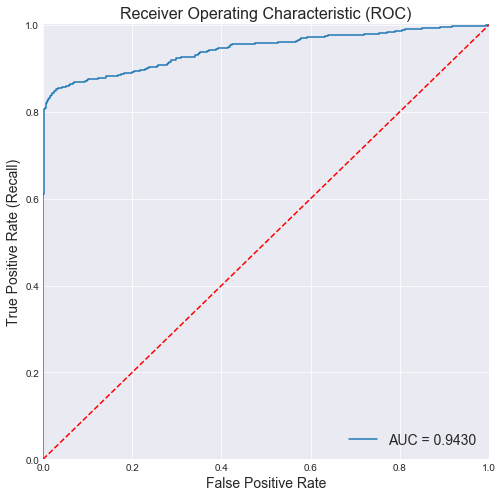

In [69]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve():
    plt.figure(figsize=(8,8))
    fpr, tpr, thresholds = roc_curve(Y_test, mse)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
    plt.plot(fpr, tpr, label='AUC = {:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right', fontsize=14)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate (Recall)', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.show();

plot_roc_curve()

### 觀察 Precision 與 Recall

- ***TP*** - True Positive 真陽性
- ***FP*** - False Positive 偽陽性
- ***TN*** - True Negative 真陰性
- ***FN*** - False Negative 偽陰性

\begin{equation}
    \textbf{Precision} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
    \textbf{Recall} = \frac{TP}{TP + FN}
\end{equation}

+ **Precision** 精確度 － 是所有預測為陽性的樣本中，真的是陽性的比例。
+ **Recall** 召回率 － **True Positive Rate**，又稱為 **Sensitivity** 敏感度，是所有實際陽性的樣本中，有被正確預測為陽性的比例。

*Low Precision*: 表示所有預測是陽性的樣本中，很多都猜錯（*High FP*）。 *Low Recall*: 表示所有實際是陽性的樣本中，有很多誤認為是陰性（*High FN*）。 若沒有其他成本考量，通常門檻值會選擇一個讓 *Precision* 和 *Recall* 都可以達到最高的值。

#### F-Measures

當有兩種模型做比較，一個模型的 Precision 比較好，另外一個模型的 Recall 比較好，這時候該怎麼選擇？ 有一個常用的 **F1 score** 可以幫助你做決定。

\begin{equation}
     \mathbf{F_{1}} = \frac{2}{ \frac{1}{Precision} + \frac{1}{Recall}} = \frac{2\cdot(Precision \cdot Recall)}{Precision + Recall}
\end{equation}

*F1 score* 計算 Precision 和 Recall 的調和平均數（harmonic mean），兩者視為同樣重要，最佳分數是 1，最差是 0。

*F-measures* 的一般形式是：

\begin{equation}
    \mathbf{F_{\beta}} = (1 + \beta^{2}) \cdot \frac{Precision \cdot Recall}{(\beta^{2} \cdot Precision) + Recall}
\end{equation}

- 當 $\beta = 1$ 時就是 *F1 score*
- 當 $\beta > 1$時，偏好 Recall 比較重要。
- 當 $\beta < 1$時，偏好 Precision 比較重要。

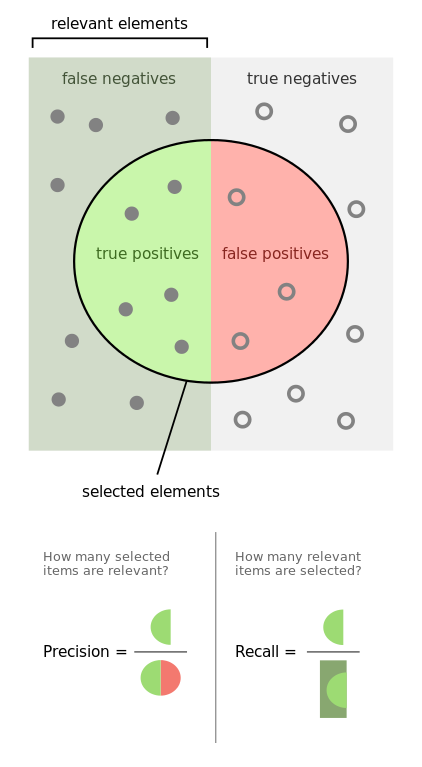

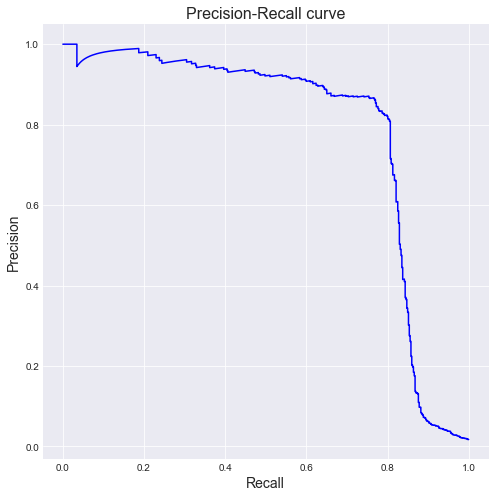

threhsold shape = (28496,) precision shape= (28497,) recall shape = (28497,)


In [70]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve():
    plt.figure(figsize=(8,8))
    precision, recall, th = precision_recall_curve(Y_test, mse)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Precision-Recall curve', fontsize=16)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.show()
    return precision, recall, th

precision, recall, th = plot_precision_recall_curve()
print('threhsold shape =', th.shape, 'precision shape=', precision.shape, 'recall shape =', recall.shape)

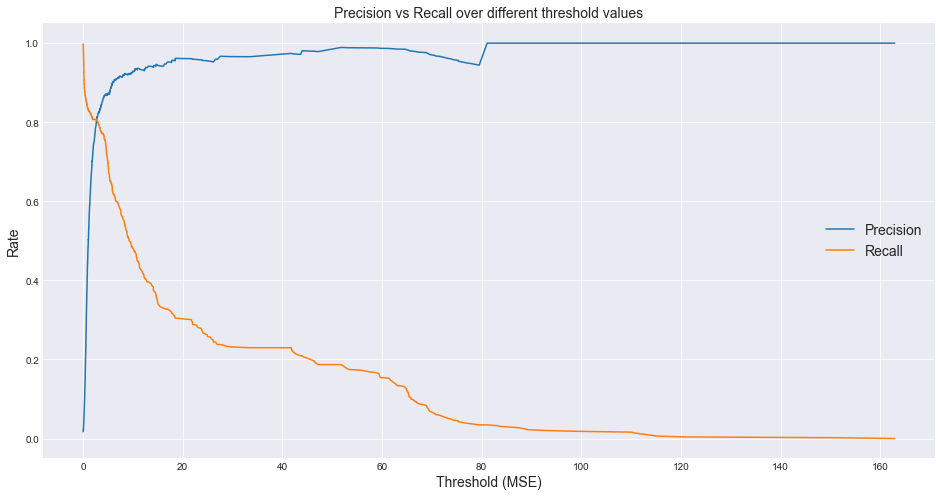

In [71]:
def plot_precisionrecall_over_thresholds():
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(th, precision[1:], label='Precision')
    ax.plot(th, recall[1:], label='Recall')
    ax.set_title('Precision vs Recall over different threshold values', fontsize=14)
    ax.set_ylabel('Rate', fontsize=14)
    ax.set_xlabel('Threshold (MSE)', fontsize=14)
    ax.legend(fontsize=14)
    plt.show()

plot_precisionrecall_over_thresholds()

用不同的門檻值觀察 Precision-Recall 曲線，可以很清楚看到，錯誤率取越高預測異常交易的 Precision 就越精準；但相對的實際異常交易 Recall 率就越低。 通常從兩條曲線的交點，我們可以取得一個 Precision-Recall 均衡的取捨點。 但還是要看實際應用情境：
- 若 *FP* 成本比較高，例如異常事件的假警報需要動用許多人力查驗來排除，那這裡的 MSE 錯誤率的門檻值就稍微取高一點，讓 Precision 較高。
- 若 *FN* 成本比較高，例如一個異常事件的損失就比動用人力查驗1000個假警報來得大，那 MSE 錯誤率門檻值就稍微取低一點，讓 Recall 較高。

In [72]:
# 取 (Precision - Recall) 絕對誤差最小的地方
pr_absdiff = np.absolute(precision - recall)
index_min = np.argmin(pr_absdiff)
print('Precision-Recall 曲線交點 #{}, 差率 {}'.format(index_min, np.amin(pr_absdiff)))

# 均衡取捨的門檻值
threshold = th[index_min - 1]
print('MSE Threshold 取 {} 時，Precision={}，Recall={}'.format(threshold, precision[index_min], recall[index_min]))

Precision-Recall 曲線交點 #28023, 差率 0.0
MSE Threshold 取 2.713246365707054 時，Precision=0.806910569105691，Recall=0.806910569105691


雖然不平衡的資料類別不適合用 confusion matrix 來評估，不過還是可以用來觀察一下預測結果還哪裡可以有改進的空間。

Precision = 0.806910569105691
Recall = 0.806910569105691
F1 score = 0.806910569105691
F100 score = 0.806910569105691
F0.01 score = 0.806910569105691


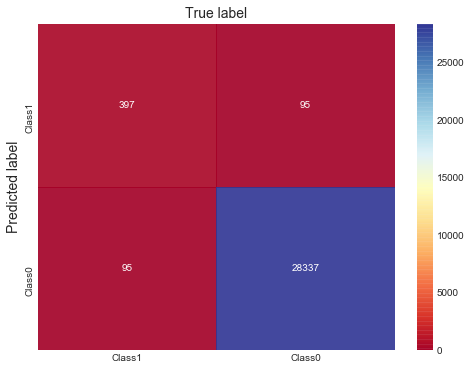

In [73]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score

# 工具函式： 畫出分類的混淆矩陣
def plot_confusion_matrix(y, y_pred):
    n_classes = np.unique(y)
    class_labels = ['Class'+str(int(n)) for n in reversed(n_classes)]
    confusion_table = pd.DataFrame(np.fliplr(np.rot90(confusion_matrix(y, y_pred))),
                                   index=class_labels,
                                   columns=class_labels)   
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion_table, annot=True, fmt='d', cmap='RdYlBu', alpha=0.9, vmin=0)    
    ax.set_title('True label', fontsize=14)
    ax.set_ylabel('Predicted label', fontsize=14)

Y_predict = [1 if e > threshold else 0 for e in mse]
plot_confusion_matrix(Y_test, Y_predict)

# show scores
print('Precision =', precision_score(Y_test, Y_predict))
print('Recall =', recall_score(Y_test, Y_predict))
print('F1 score =', fbeta_score(Y_test, Y_predict, beta=1))
print('F100 score =', fbeta_score(Y_test, Y_predict, beta=100))
print('F0.01 score =', fbeta_score(Y_test, Y_predict, beta=0.01))

看起來沒被抓出來的異常交易有點高，如果按照一個異常交易的損失差不多是查驗100個假警報的成本，我們降低 MSE 門檻值，讓 Recall 大一點看看。

In [74]:
# 偏好 Recall 的門檻值
index_prefer_recall = index_min - 5600
threshold_prefer_recall = th[index_prefer_recall - 1]
print('MSE Threshold 取 {} 時，Precision={}，Recall={}'.format(
    threshold_prefer_recall, precision[index_prefer_recall], recall[index_prefer_recall]))

MSE Threshold 取 0.23312392874465185 時，Precision=0.07179150958859204，Recall=0.8902439024390244


Precision = 0.07179150958859204
Recall = 0.8902439024390244
F1 score = 0.13286819353860155
F100 score = 0.889230245177677
F0.01 score = 0.0717981097415179


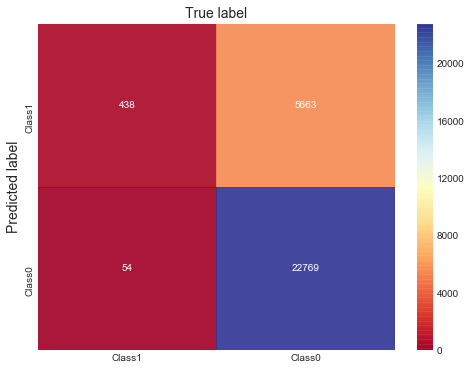

In [75]:
# 劃出新門檻值的 confusion matrix
Y_predict_prefer_recall = [1 if e > threshold_prefer_recall else 0 for e in mse]
plot_confusion_matrix(Y_test, Y_predict_prefer_recall)

# show scores
print('Precision =', precision_score(Y_test, Y_predict_prefer_recall))
print('Recall =', recall_score(Y_test, Y_predict_prefer_recall))
print('F1 score =', fbeta_score(Y_test, Y_predict_prefer_recall, beta=1))
print('F100 score =', fbeta_score(Y_test, Y_predict_prefer_recall, beta=100))
print('F0.01 score =', fbeta_score(Y_test, Y_predict_prefer_recall, beta=0.01))

### 結論

我們用深度自編碼器示範了一個可以用來偵測異常的預測模型，結果顯然還有待改進。 但以上範例只是個展示概念可行的雛形，要建立一個實用的預測模型，還需要加入一些模型訓練的技巧，例如可以加入另外一個分類的網路，在每次迭代訓練評估 loss 時就一起評估分類結果的得分，而且在做交叉驗證時，也應該就用包含正常及異常類別的資料集來做驗證。

<a id="references"></a>

## References:

+ Ian Goodfellow and Yoshua Bengio and Aaron Courville, *"Deep Learning"*, MIT Press, 2016. [[link]](http://www.deeplearningbook.org)
+ Wikipedia contributors, *"Autoencoder"*, Wikipedia, The Free Encyclopedia. [[link]](https://en.wikipedia.org/w/index.php?title=Autoencoder&oldid=905990949).
+ Francois Chollet, *"Building Autoencoders in Keras"*, The Keras Blog, 2016. [[link]](https://blog.keras.io/building-autoencoders-in-keras.html)
+ Venelin Valkov, *"Credit Card Fraud Detection using Autoencoders in Keras"*, Curiousily, 2017. [[link]](https://www.curiousily.com/posts/credit-card-fraud-detection-using-autoencoders-in-keras/)
+ Jason Brownlee, *"How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python"*, Machine Learning Mastery, 2018. [[link]](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
+ Wikipedia contributors, *"F1 score"*, Wikipedia, The Free Encyclopedia. [[link]](https://en.wikipedia.org/w/index.php?title=F1_score&oldid=907526484).